In [14]:
import os
import cv2
import glob
import sys
import configparser
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, Dataset
from torchvision import models, datasets
from torchvision.datasets import ImageFolder
from DeepCNNModel import DeepCNN

from PIL import Image
from tqdm import tqdm

In [2]:
model_name = "effinet_v2.pth"
batch_size = 128
num_epochs = 30

In [3]:
mean_ = [0.485, 0.456, 0.406]
std_ = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=list(mean_), std=list(std_)),
])

# transform_train = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

In [4]:
train_data = ImageFolder(root = "augmented_images/train", 
                   transform = transform_train)
val_data = ImageFolder(root = "augmented_images/val", 
                   transform = transform_train)

In [5]:
# DataLoader 설정
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [6]:
# model = DeepCNN()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
model = models.efficientnet_v2_s(weights="DEFAULT")

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 9)

In [8]:
model.to(device)

model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [9]:
def train_and_validate_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=25):
    best_acc = 0.0
    train_score = []
    val_score = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        with tqdm(train_loader, ncols=160, ascii=" =", unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}")

                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

                tepoch.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_score.append((epoch_loss, epoch_acc.to("cpu").numpy()))

        # 검증 단계
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_score.append((val_loss, val_acc.to("cpu").numpy()))

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # 모델 저장 조건 추가: 현재 검증 정확도가 지금까지의 최고보다 더 높으면 모델 저장
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_name)

    return model, train_score, val_score

In [10]:
model, train_score, val_score = train_and_validate_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)

Epoch 1: 100%|=================================================================================================| 704/704 [05:47<00:00,  2.02batch/s, loss=0.612]


Epoch 1/30, Train Loss: 0.4572, Train Acc: 0.8404, Val Loss: 0.4116, Val Acc: 0.8723


Epoch 2: 100%|=================================================================================================| 704/704 [05:47<00:00,  2.03batch/s, loss=0.629]


Epoch 2/30, Train Loss: 0.2385, Train Acc: 0.9176, Val Loss: 0.1870, Val Acc: 0.9410


Epoch 3: 100%|=================================================================================================| 704/704 [05:47<00:00,  2.03batch/s, loss=0.353]


Epoch 3/30, Train Loss: 0.1944, Train Acc: 0.9334, Val Loss: 0.5586, Val Acc: 0.8333


Epoch 4: 100%|================================================================================================| 704/704 [05:48<00:00,  2.02batch/s, loss=0.0657]


Epoch 4/30, Train Loss: 0.1607, Train Acc: 0.9440, Val Loss: 0.3264, Val Acc: 0.9092


Epoch 5: 100%|=================================================================================================| 704/704 [05:48<00:00,  2.02batch/s, loss=0.134]


Epoch 5/30, Train Loss: 0.1477, Train Acc: 0.9490, Val Loss: 0.1127, Val Acc: 0.9640


Epoch 6: 100%|=================================================================================================| 704/704 [05:47<00:00,  2.03batch/s, loss=0.347]


Epoch 6/30, Train Loss: 0.1352, Train Acc: 0.9539, Val Loss: 0.1421, Val Acc: 0.9556


Epoch 7: 100%|=================================================================================================| 704/704 [05:47<00:00,  2.02batch/s, loss=0.219]


Epoch 7/30, Train Loss: 0.1245, Train Acc: 0.9565, Val Loss: 0.3175, Val Acc: 0.9054


Epoch 8: 100%|================================================================================================| 704/704 [05:46<00:00,  2.03batch/s, loss=0.0425]


Epoch 8/30, Train Loss: 0.1127, Train Acc: 0.9612, Val Loss: 0.1562, Val Acc: 0.9564


Epoch 9: 100%|=================================================================================================| 704/704 [05:46<00:00,  2.03batch/s, loss=0.262]


Epoch 9/30, Train Loss: 0.1046, Train Acc: 0.9650, Val Loss: 0.1801, Val Acc: 0.9468


Epoch 10: 100%|================================================================================================| 704/704 [05:46<00:00,  2.03batch/s, loss=0.128]


Epoch 10/30, Train Loss: 0.1000, Train Acc: 0.9659, Val Loss: 0.1096, Val Acc: 0.9663


Epoch 11: 100%|================================================================================================| 704/704 [05:46<00:00,  2.03batch/s, loss=0.338]


Epoch 11/30, Train Loss: 0.0952, Train Acc: 0.9670, Val Loss: 0.1672, Val Acc: 0.9513


Epoch 12: 100%|=================================================================================================| 704/704 [05:46<00:00,  2.03batch/s, loss=0.32]


Epoch 12/30, Train Loss: 0.0825, Train Acc: 0.9711, Val Loss: 0.3151, Val Acc: 0.9193


Epoch 13: 100%|================================================================================================| 704/704 [05:46<00:00,  2.03batch/s, loss=0.656]


Epoch 13/30, Train Loss: 0.0819, Train Acc: 0.9714, Val Loss: 0.1546, Val Acc: 0.9569


Epoch 14: 100%|================================================================================================| 704/704 [05:46<00:00,  2.03batch/s, loss=0.197]


Epoch 14/30, Train Loss: 0.0787, Train Acc: 0.9732, Val Loss: 0.1821, Val Acc: 0.9545


Epoch 15: 100%|================================================================================================| 704/704 [05:47<00:00,  2.03batch/s, loss=0.301]


Epoch 15/30, Train Loss: 0.0663, Train Acc: 0.9774, Val Loss: 0.3749, Val Acc: 0.9054


Epoch 16: 100%|================================================================================================| 704/704 [05:47<00:00,  2.03batch/s, loss=0.614]


Epoch 16/30, Train Loss: 0.0708, Train Acc: 0.9763, Val Loss: 0.1468, Val Acc: 0.9607


Epoch 17: 100%|===============================================================================================| 704/704 [05:47<00:00,  2.03batch/s, loss=0.0978]


Epoch 17/30, Train Loss: 0.0615, Train Acc: 0.9789, Val Loss: 0.2946, Val Acc: 0.9259


Epoch 18: 100%|================================================================================================| 704/704 [05:47<00:00,  2.02batch/s, loss=0.226]


Epoch 18/30, Train Loss: 0.0738, Train Acc: 0.9754, Val Loss: 0.0958, Val Acc: 0.9739


Epoch 19: 100%|==============================================================================================| 704/704 [05:47<00:00,  2.02batch/s, loss=0.00165]


Epoch 19/30, Train Loss: 0.0575, Train Acc: 0.9805, Val Loss: 0.1583, Val Acc: 0.9605


Epoch 20: 100%|==============================================================================================| 704/704 [05:48<00:00,  2.02batch/s, loss=0.00807]


Epoch 20/30, Train Loss: 0.0436, Train Acc: 0.9847, Val Loss: 0.2482, Val Acc: 0.9430


Epoch 21: 100%|================================================================================================| 704/704 [05:47<00:00,  2.02batch/s, loss=0.587]


Epoch 21/30, Train Loss: 0.0487, Train Acc: 0.9832, Val Loss: 0.1988, Val Acc: 0.9580


Epoch 22: 100%|================================================================================================| 704/704 [05:48<00:00,  2.02batch/s, loss=0.241]


Epoch 22/30, Train Loss: 0.0543, Train Acc: 0.9819, Val Loss: 0.1931, Val Acc: 0.9574


Epoch 23: 100%|=============================================================================================| 704/704 [05:48<00:00,  2.02batch/s, loss=0.000627]


Epoch 23/30, Train Loss: 0.0455, Train Acc: 0.9843, Val Loss: 0.1754, Val Acc: 0.9594


Epoch 24: 100%|=============================================================================================| 704/704 [05:47<00:00,  2.02batch/s, loss=0.000333]


Epoch 24/30, Train Loss: 0.0460, Train Acc: 0.9848, Val Loss: 0.1384, Val Acc: 0.9647


Epoch 25: 100%|================================================================================================| 704/704 [05:47<00:00,  2.02batch/s, loss=0.538]


Epoch 25/30, Train Loss: 0.0418, Train Acc: 0.9858, Val Loss: 0.2887, Val Acc: 0.9405


Epoch 26: 100%|================================================================================================| 704/704 [05:47<00:00,  2.03batch/s, loss=0.195]


Epoch 26/30, Train Loss: 0.0479, Train Acc: 0.9839, Val Loss: 0.1398, Val Acc: 0.9667


Epoch 27: 100%|=================================================================================================| 704/704 [05:48<00:00,  2.02batch/s, loss=4.26]


Epoch 27/30, Train Loss: 0.0386, Train Acc: 0.9869, Val Loss: 0.1337, Val Acc: 0.9704


Epoch 28: 100%|=============================================================================================| 704/704 [05:48<00:00,  2.02batch/s, loss=0.000386]


Epoch 28/30, Train Loss: 0.0446, Train Acc: 0.9851, Val Loss: 0.2049, Val Acc: 0.9595


Epoch 29: 100%|==============================================================================================| 704/704 [05:48<00:00,  2.02batch/s, loss=0.00532]


Epoch 29/30, Train Loss: 0.0327, Train Acc: 0.9888, Val Loss: 0.2538, Val Acc: 0.9475


Epoch 30: 100%|===============================================================================================| 704/704 [05:48<00:00,  2.02batch/s, loss=0.0643]


Epoch 30/30, Train Loss: 0.0339, Train Acc: 0.9887, Val Loss: 0.2634, Val Acc: 0.9469


In [16]:
train_loss, train_acc = zip(*train_score)
val_loss, val_acc = zip(*val_score)

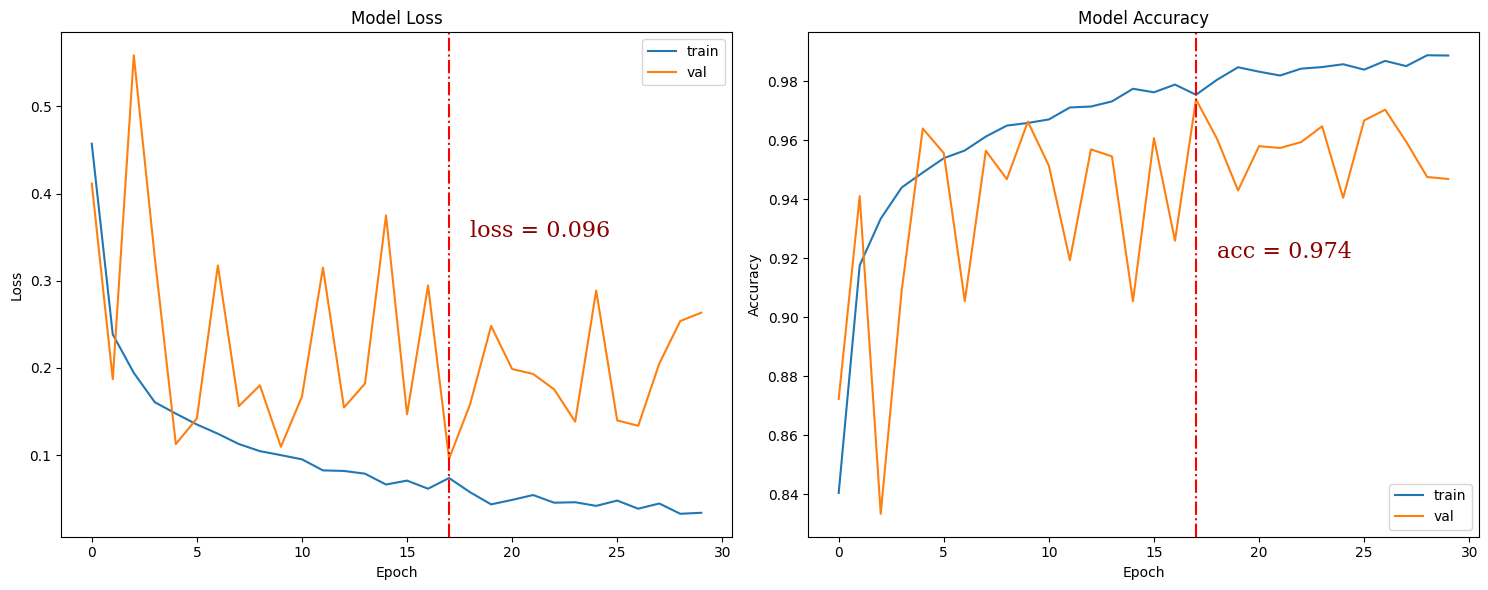

In [44]:
plt.figure(figsize=(15,6))
font1 = {'family': 'serif',
      'color':  'darkred',
      'weight': 'normal',
      'size': 16}

# 훈련 손실 그래프
plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.axvline(np.argmax(val_acc), color="r", linestyle="dashdot")
plt.text(18.0, 0.35, f"loss = {np.round(np.min(val_loss), 3)}", fontdict=font1)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

# 훈련 정확도 그래프
plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.axvline(np.argmax(val_acc), color="r", linestyle="dashdot")
plt.text(18.0, 0.92, f"acc = {np.round(np.max(val_acc), 3)}", fontdict=font1)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.tight_layout()
plt.show()

In [62]:
test_dataset = datasets.ImageFolder("./augmented_images/test", transform=transform_train)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(tuple(test_dataset.class_to_idx.keys()))

('Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch', 'none')


In [63]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in tuple(test_dataset.class_to_idx.keys())}
total_pred = {classname: 0 for classname in tuple(test_dataset.class_to_idx.keys())}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[tuple(test_dataset.class_to_idx.keys())[label]] += 1
            total_pred[tuple(test_dataset.class_to_idx.keys())[label]] += 1

# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Center is 97.3 %
Accuracy for class: Donut is 91.2 %
Accuracy for class: Edge-Loc is 85.7 %
Accuracy for class: Edge-Ring is 99.0 %
Accuracy for class: Loc   is 83.1 %
Accuracy for class: Near-full is 95.8 %
Accuracy for class: Random is 93.7 %
Accuracy for class: Scratch is 87.2 %
Accuracy for class: none  is 94.8 %


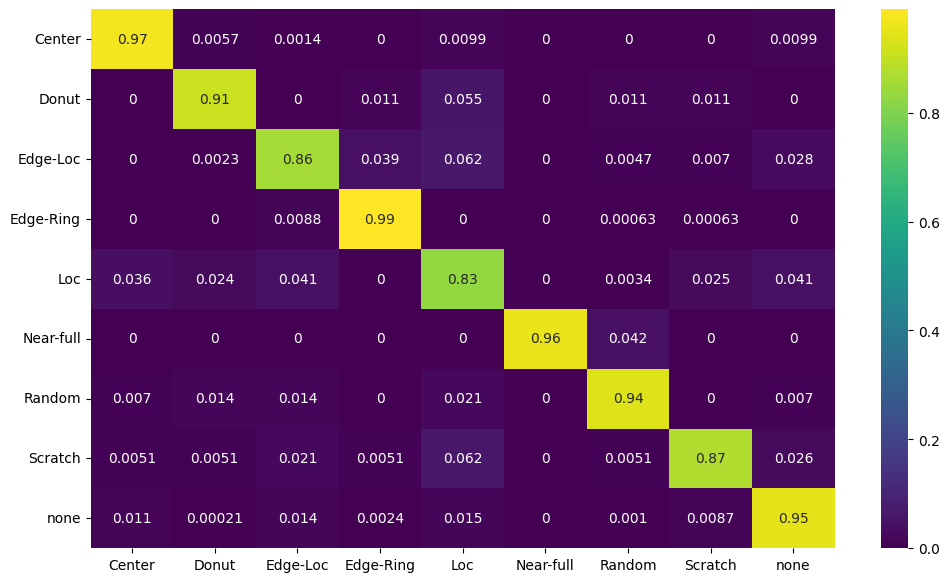

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for inputs, labels in test_loader:
            output = model(inputs) # Feed Network
    
            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

# constant for classes
classes = tuple(test_dataset.class_to_idx.keys())

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, cmap = 'viridis')
plt.savefig('output.png')